In [4]:
import time
import csv
from tqdm import tqdm
import collections
import sys
import os
import openpyxl
import re
import pandas as pd
import numpy as np
import json
import warnings
import xlsxwriter
import sklearn
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets				# 내장 데이터 사용
from sklearn.model_selection import train_test_split	# train, test 데이터 분할
from keras.utils import to_categorical

from sklearn.linear_model import LinearRegression	# 선형 회귀분석
from sklearn.linear_model import LogisticRegression	# 로지스틱 회귀분석
from sklearn.naive_bayes import GaussianNB		# 나이브 베이즈
from sklearn import svm					# 서포트 벡터 머신
from sklearn import tree				# 의사결정나무
from sklearn.ensemble import RandomForestClassifier	# 랜덤포레스트

from sklearn.datasets import make_classification
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report


In [2]:
# content = pd.read_excel('F:/02. 유영은(박사과정)/OneDrive - 충북대학교/05. 수업/08. AI 교육/ICT/spatial_category/gir_landuse_binary.xlsx')
content = pd.read_excel('/Users/youngeun/Library/CloudStorage/OneDrive-충북대학교/05. 수업/08. AI 교육/ICT/spatial_category/gir_landuse_binary.xlsx')
content

,ID,년도,시군구,산업(에너지산업 포함),수송(도로),수송(해운),수송(항공),수송(철도 및 기타),가정,상업/공공,...,폐기물,순배출량,총배출량,주거,상업,공업,녹지,도농,type,class
0,1,2020,강원_강릉시,2083865,435547,3400,367,89803,300260,425348,...,154098,5996492,6629677,0.023249,0.002449,0.007608,0.072632,0.894062,도농,5
1,2,2020,강원_고성군,43710,55157,0,0,0,38674,90022,...,16174,-140118,324258,0.008965,0.001150,0.000600,0.024243,0.965042,도농,5
2,3,2020,강원_동해시,2890367,176244,6166,0,531,123163,151010,...,61268,8370666,8482792,0.087770,0.014250,0.059450,0.543740,0.294790,녹지,4
3,4,2020,강원_삼척시,5022982,124887,230,0,561,125620,185856,...,49728,8619953,9305902,0.009543,0.000952,0.007405,0.053718,0.928382,도농,5
4,5,2020,강원_속초시,27626,148327,0,0,7,121526,178000,...,62167,462186,552797,0.169990,0.062598,0.029240,0.738172,0.000000,녹지,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369,1370,2015,충북_제천시,1604959,288644,0,142,7226,242281,283115,...,81561,4111594,4465011,0.011409,0.002047,0.005732,0.079758,0.901054,도농,5
1370,1371,2015,충북_증평군,222774,73815,0,0,1430,48022,60644,...,17083,407914,462626,0.061151,0.005401,0.035780,0.193115,0.704553,도농,5
1371,1372,2015,충북_진천군,951474,150897,0,570,360,89454,152872,...,95416,1584276,1801926,0.021845,0.002120,0.015374,0.051388,0.909272,도농,5
1372,1373,2015,충북_청주시,3963163,1652455,0,39662,22307,1329257,1433665,...,939416,9769034,10278839,0.060109,0.006961,0.026848,0.417691,0.488391,도농,5


In [3]:
content.loc[content.duplicated() ,:]

,ID,년도,시군구,산업(에너지산업 포함),수송(도로),수송(해운),수송(항공),수송(철도 및 기타),가정,상업/공공,...,폐기물,순배출량,총배출량,주거,상업,공업,녹지,도농,type,class


In [12]:
x_data = pd.DataFrame(content[content.columns[3:14]])
y_data = content.loc[:,'class']

print(x_data[0:5])
print(y_data[0:5])

   산업(에너지산업 포함)  수송(도로)  수송(해운)  수송(항공)  수송(철도 및 기타)      가정   상업/공공     산업공정  \
0       2083865  435547    3400     367        89803  300260  425348  3020664   
1         43710   55157       0       0            0   38674   90022        2   
2       2890367  176244    6166       0          531  123163  151010  5061718   
3       5022982  124887     230       0          561  125620  185856  3741502   
4         27626  148327       0       0            7  121526  178000        3   

   AFOLU(농업)  AFOLU(LULUCF)     폐기물  
0     116325        -633185  154098  
1      80519        -464376   16174  
2      12325        -112126   61268  
3      54536        -685949   49728  
4      15141         -90611   62167  
0    5
1    5
2    4
3    5
4    4
Name: class, dtype: int64


In [13]:
#전체 중 20%를 테스트용으로 분할,나머지 80%는 훈련용
(x_train, x_valid, y_train, y_valid) = train_test_split(x_data, y_data, train_size=0.8, random_state=1)

#원-핫 인코딩(one-hot encoding)
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)

#5개씩만 출력
print(y_train[:5])
print(y_valid[:5])

[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]]
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]


In [14]:
from keras import Sequential
from keras.layers import Dense, Activation

# 모델을 준비한다.
model = Sequential()

# 입력 변수의 개수가 4이고 출력 개수가 3
model.add(Dense(3, input_dim=4, activation='softmax'))

# Loss funtion과 Optimizer를 선택한다.
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy']) 

# epochs만큼 반복
hist=model.fit(x_train, y_train, epochs=500, batch_size=20,validation_data=(x_valid, y_valid))

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-10-06 01:21:33.016897: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-06 01:21:33.016944: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-06 01:21:33.225897: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/500


ValueError: in user code:

    File "/opt/anaconda3/envs/ICT/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/envs/ICT/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/envs/ICT/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/envs/ICT/lib/python3.10/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/opt/anaconda3/envs/ICT/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/envs/ICT/lib/python3.10/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 4), found shape=(None, 11)


In [28]:
linnerud = sklearn.datasets.load_linnerud()
print(linnerud.DESCR)

.. _linnerrud_dataset:

Linnerrud dataset
-----------------

**Data Set Characteristics:**

    :Number of Instances: 20
    :Number of Attributes: 3
    :Missing Attribute Values: None

The Linnerud dataset is a multi-output regression dataset. It consists of three
exercise (data) and three physiological (target) variables collected from
twenty middle-aged men in a fitness club:

- *physiological* - CSV containing 20 observations on 3 physiological variables:
   Weight, Waist and Pulse.
- *exercise* - CSV containing 20 observations on 3 exercise variables:
   Chins, Situps and Jumps.

.. topic:: References

  * Tenenhaus, M. (1998). La regression PLS: theorie et pratique. Paris:
    Editions Technic.



In [57]:
df = pd.concat([pd.DataFrame(linnerud.data, columns=linnerud.feature_names),
                pd.DataFrame(linnerud.target, columns=linnerud.target_names)],
               axis=1)
df

,Chins,Situps,Jumps,Weight,Waist,Pulse
0,5.0,162.0,60.0,191.0,36.0,50.0
1,2.0,110.0,60.0,189.0,37.0,52.0
2,12.0,101.0,101.0,193.0,38.0,58.0
3,12.0,105.0,37.0,162.0,35.0,62.0
4,13.0,155.0,58.0,189.0,35.0,46.0
5,4.0,101.0,42.0,182.0,36.0,56.0
6,8.0,101.0,38.0,211.0,38.0,56.0
7,6.0,125.0,40.0,167.0,34.0,60.0
8,15.0,200.0,40.0,176.0,31.0,74.0
9,17.0,251.0,250.0,154.0,33.0,56.0


In [115]:
X = df[['Chins','Situps','Jumps']]
X

,Chins,Situps,Jumps
0,5.0,162.0,60.0
1,2.0,110.0,60.0
2,12.0,101.0,101.0
3,12.0,105.0,37.0
4,13.0,155.0,58.0
5,4.0,101.0,42.0
6,8.0,101.0,38.0
7,6.0,125.0,40.0
8,15.0,200.0,40.0
9,17.0,251.0,250.0


In [116]:
Y = df[['Weight','Waist','Pulse']]
Y

,Weight,Waist,Pulse
0,191.0,36.0,50.0
1,189.0,37.0,52.0
2,193.0,38.0,58.0
3,162.0,35.0,62.0
4,189.0,35.0,46.0
5,182.0,36.0,56.0
6,211.0,38.0,56.0
7,167.0,34.0,60.0
8,176.0,31.0,74.0
9,154.0,33.0,56.0


In [93]:
x = pd.DataFrame(content[content.columns[2:13]])
x = x.drop(['AFOLU(LULUCF)'], axis = 'columns')
x

,산업(에너지산업 포함),수송(도로),수송(해운),수송(항공),수송(철도 및 기타),가정,상업/공공,산업공정,AFOLU(농업),폐기물
0,2083865,435547,3400,367,89803,300260,425348,3020664,116325,154098
1,43710,55157,0,0,0,38674,90022,2,80519,16174
2,2890367,176244,6166,0,531,123163,151010,5061718,12325,61268
3,5022982,124887,230,0,561,125620,185856,3741502,54536,49728
4,27626,148327,0,0,7,121526,178000,3,15141,62167
...,...,...,...,...,...,...,...,...,...,...
1369,1604959,288644,0,142,7226,242281,283115,1860947,96136,81561
1370,222774,73815,0,0,1430,48022,60644,3,38855,17083
1371,951474,150897,0,570,360,89454,152872,142885,217998,95416
1372,3963163,1652455,0,39662,22307,1329257,1433665,463526,435388,939416


In [107]:
x = np.array(x)
x 

array([[2083865,  435547,    3400, ..., 3020664,  116325,  154098],
       [  43710,   55157,       0, ...,       2,   80519,   16174],
       [2890367,  176244,    6166, ..., 5061718,   12325,   61268],
       ...,
       [ 951474,  150897,       0, ...,  142885,  217998,   95416],
       [3963163, 1652455,       0, ...,  463526,  435388,  939416],
       [ 739407,  416507,     243, ...,     -10,  221290,  112551]],
      dtype=int64)

In [155]:
y = content[content.columns[15:20]]*100
# y = round(y,2)
y = y.astype('int')
print(y.dtypes)
y

주거    int32
상업    int32
공업    int32
녹지    int32
도농    int32
dtype: object


,주거,상업,공업,녹지,도농
0,2,0,0,7,89
1,0,0,0,2,96
2,8,1,5,54,29
3,0,0,0,5,92
4,16,6,2,73,0
...,...,...,...,...,...
1369,1,0,0,7,90
1370,6,0,3,19,70
1371,2,0,1,5,90
1372,6,0,2,41,48


In [156]:
y = np.array(y)
y

array([[ 2,  0,  0,  7, 89],
       [ 0,  0,  0,  2, 96],
       [ 8,  1,  5, 54, 29],
       ...,
       [ 2,  0,  1,  5, 90],
       [ 6,  0,  2, 41, 48],
       [ 2,  0,  1, 12, 82]])

In [162]:
xtrain, xtest, ytrain, ytest=train_test_split(x, y, train_size=0.90, random_state=0)

In [163]:
xtrain, ytrain

(array([[  53683,  638521,       0, ...,    1608,    1580,  105373],
        [ 203514,  222061,       0, ...,       6,  359988,   45379],
        [  96239,  166992,       0, ...,       4,  402047,   28387],
        ...,
        [ 109449,   53906,       0, ...,    1063,  141256,    8736],
        [  23772,  802117,       0, ...,      12,    1271,  119141],
        [1280138,  180446,       0, ...,  228869,  185882,   87640]],
       dtype=int64),
 array([[19,  2,  0, 77,  0],
        [ 1,  0,  0,  4, 94],
        [ 2,  0,  0,  8, 87],
        ...,
        [ 0,  0,  0,  1, 98],
        [23,  2,  0, 73,  0],
        [ 2,  0,  2,  5, 90]]))

In [228]:
clf = MultiOutputClassifier(KNeighborsClassifier()).fit(xtrain, ytrain)
clf.predict(xtrain)

array([[19,  2,  0, 22,  0],
       [ 1,  0,  0,  4, 94],
       [ 2,  0,  0,  8, 88],
       ...,
       [ 0,  0,  0,  1, 98],
       [23,  2,  0, 73,  0],
       [ 2,  0,  2,  5, 90]])

In [231]:
reg = MultiOutputRegressor(GradientBoostingRegressor(random_state=0)).fit(xtrain, ytrain)
reg.predict(xtrain)

array([[ 2.32917901e+01,  2.89224399e+00,  2.86216624e+00,
         6.70421777e+01,  9.44278616e-01],
       [ 1.67709102e+00, -4.46202745e-02, -1.30057487e-01,
         1.12456325e+01,  9.19066631e+01],
       [ 3.89584189e-02, -1.89281294e-04,  1.08155957e-01,
         5.57946525e+00,  9.64275683e+01],
       ...,
       [ 1.75469373e-01, -5.00074217e-02,  1.56919092e-01,
         2.48533644e+00,  9.60060909e+01],
       [ 3.02452259e+01,  2.66591992e+00,  6.01487084e-01,
         6.59882171e+01,  1.16642316e+00],
       [ 2.23660864e+00, -1.45892618e-01,  1.77306174e+00,
         1.49196517e+01,  8.38889809e+01]])

In [244]:
from sklearn.ensemble import RandomForestRegressor
max_depth = 30

regr = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr.fit(xtrain, ytrain)

regr_rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth,
                                random_state=2)
regr_rf.fit(xtrain, ytrain)

RandomForestRegressor(max_depth=30, random_state=2)

In [245]:
y_multirf = regr.predict(xtest)
y_rf = regr_rf.predict(xtest)

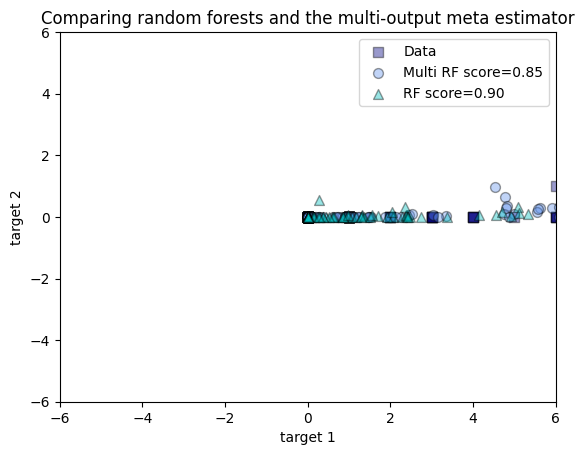

In [246]:
import matplotlib.pyplot as plt

plt.figure()
s = 50
a = 0.4
plt.scatter(ytest[:, 0], ytest[:, 1], edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Data")
plt.scatter(y_multirf[:, 0], y_multirf[:, 1], edgecolor='k',
            c="cornflowerblue", s=s, alpha=a,
            label="Multi RF score=%.2f" % regr.score(xtest, ytest))
plt.scatter(y_rf[:, 0], y_rf[:, 1], edgecolor='k',
            c="c", s=s, marker="^", alpha=a,
            label="RF score=%.2f" % regr_rf.score(xtest, ytest))
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.xlabel("target 1")
plt.ylabel("target 2")
plt.title("Comparing random forests and the multi-output meta estimator")
plt.legend()
plt.show()

In [232]:
print(clf.score(xtrain,ytrain))
print(reg.score(xtrain,ytrain))

0.7257281553398058
0.9516617941675138


In [242]:
roc_auc_score(ytest, np.transpose([pred[:, 1] for pred in clf.predict_proba(xtest)]), multi_class='ovr')

ValueError: multiclass-multioutput format is not supported

In [230]:
yhat = clf.predict_proba(xtest)
yhat = np.transpose([pred[:, 1] for pred in yhat])

print(xtest[0])
print(ytest[0])
print(yhat[0])
print(len(yhat), len(xtest), len(ytest))

roc_auc_score(ytest, yhat)

[526942 123167    176      0   3481  83037 134893   6786 322631  50050]
[ 1  0  1  5 90]
[0.8 0.  1.  0.  0. ]
138 138 138


ValueError: multiclass-multioutput format is not supported

In [194]:
from sklearn.datasets import load_iris 
X, y = load_iris(return_X_y=True)
print(X[0], y[0])
clf = LogisticRegression(solver="liblinear").fit(X, y)
# roc_auc_score(y, clf.predict_proba(X), multi_class='ovr')

print(clf.predict_proba(X)[0])

[5.1 3.5 1.4 0.2] 0
[8.78030305e-01 1.21958900e-01 1.07949250e-05]
